## GraphSAGE Testing:

Notebook to run trained GraphSAGE model on test data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random

print(torch.__version__)
print(torch.version.cuda)

from torch_geometric.data import Batch
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader, LinkNeighborLoader
# from torch_geometric.nn import GraphSAGE
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn

2.1.0
None


### Load Data:

(The dataset has already been split into train, val and test)

In [2]:
data_path = 'split_data/10_class_50yrN_split.pkl' # change as needed
with open(data_path, 'rb') as f:
    # Load the serialized object from the file
    tune_data = pickle.load(f)

print(tune_data)

Data(x=[1000, 24], edge_index=[2, 100000], edge_attr=[100000, 1], y=[1000], train_mask=[1000], val_mask=[1000], test_mask=[1000])


### Define GCN Model and load saved state:

In [42]:
class GraphSAGE(torch.nn.Module):
    '''GraphSAGE Model'''

    # Define layers:
    def __init__(self, dim_in, dim_h, num_classes):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_h // 2)
        self.linear = torch.nn.Linear(dim_h // 2, num_classes)

    # Define forward function:
    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.linear(h)

        return h # return single numeric value

In [43]:
model_path = 'saved_models/SAGE_best_model_10Classes_50yrN.pth'

dim_in = tune_data.num_features
dim_h = 64
num_classes = 10
model = GraphSAGE(dim_in, dim_h, num_classes)

model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Define test function:

In [44]:
def test_model(model, data, data_loader, print_metrics=True):
    ''' 
    Function to train a GraphSAGE model.

    Inputs:
    - model (torch.nn.Module): GraphSAGE model
    - data_loader (pytorch_geometric.loader.NeighborLoader)
    - print_metrics (bool): Whether to print testing results (Default = True)

    Returns:
    - test_accuracy (float): Test accuracy
    
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Test init:
    model.eval()

    test_accuracy = 0
    test_correct = 0
    test_total = 0
    num_batches = len(data_loader)
    all_preds = []
    all_labels = []

    # Test in mini-batches:
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)

            # Feed data through model:
            out = model(batch.x, batch.edge_index)

            # Calculate test accuracy
            pred = out.argmax(dim=1)
            correct = pred[batch.test_mask] == batch.y[batch.test_mask]
            test_correct += correct.sum().item()
            test_total += batch.test_mask.sum().item()

            # Append for confusion matrix
            all_preds.append(pred[batch.test_mask].cpu().numpy())
            all_labels.append(batch.y[batch.test_mask].cpu().numpy())

    
    test_accuracy = test_correct / test_total

    if print_metrics:    
        print('Test accuracy: ', test_accuracy)

        # Convert prediction and label tensors to numpy arrays
        preds = np.concatenate(all_preds)
        labels = np.concatenate(all_labels)

        # Build confusion matrix:
        if num_classes == 4:
            classes = ('1700', '1750', '1800', '1850')
        if num_classes == 5:
            classes = ('1650', '1700', '1750', '1800', '1850') 
        if num_classes == 10:
            classes = ('1650', '1675', '1700', '1725', '1750', '1775', '1800',  '1825', '1850', '1875')
        cf_matrix = confusion_matrix(labels, preds) # build confusion matrix
        cf_matrix_df = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes]) # normalise, convert to cols, store in dataframe 
        plt.figure(figsize = (12,7))
        plt.title('Folk-Song Dating Confusion Matrix')
        sn.heatmap(cf_matrix_df, annot=True)


    return test_accuracy

### Test model:

In [58]:
data_loader = NeighborLoader(
        tune_data,
        num_neighbors=[15, 30], # n neighbours of a node and n neighbours for each of these neighbours
        batch_size = 800,
        input_nodes=tune_data.test_mask)

In [ ]:
for batch in data_loader:
    print(batch)

Test accuracy:  0.20318725099601595


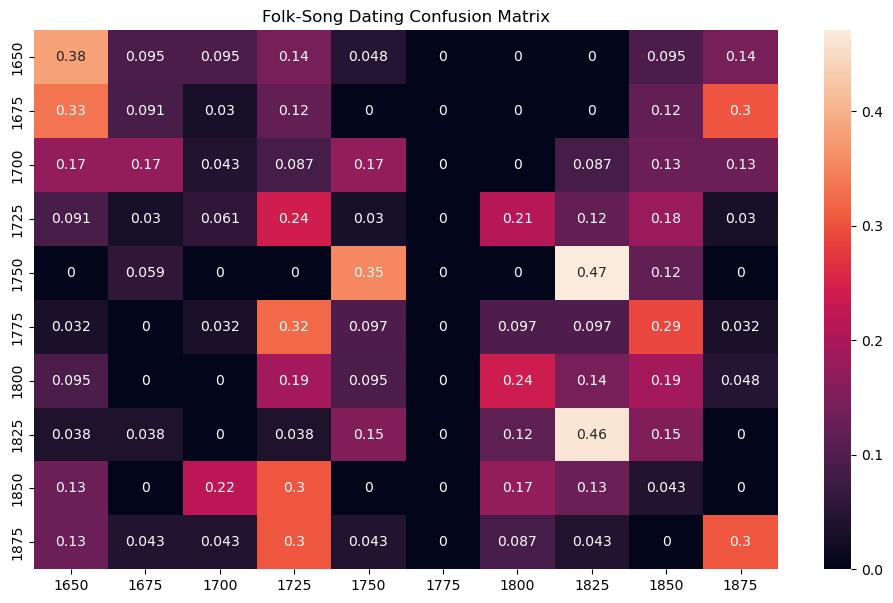

In [69]:
test_accuracy = test_model(model, tune_data, data_loader, num_classes)